In [1]:
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import io
import gc
import os
import contextlib
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async' # to fix GPU issues
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, Conv2D, concatenate, Layer, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.activations import relu, tanh, linear
from tensorflow.keras.utils import Progbar, to_categorical
from tensorflow.keras import backend as K
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from scipy.signal import butter, lfilter
from joblib import Parallel, delayed #Paralleize calculation
from sqlalchemy import create_engine, Column, Integer, ARRAY, MetaData, Table, Text
from sqlalchemy.dialects.postgresql import ARRAY as PG_ARRAY
from psycopg2.extensions import register_adapter, AsIs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

# Set random seed for reproducability
tf.keras.utils.set_random_seed(42)
# check if tensorflow uses GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-01-18 21:09:56.976518: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 21:09:57.756527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


In [5]:
# Custom adapter function for postgre
def adapt_numpy_ndarray(numpy_array):
    return AsIs(list(numpy_array))
# Register the postgre-adapter
register_adapter(np.ndarray, adapt_numpy_ndarray)

# Database connection parameters and alchemy engine
dbname = 'bathunting'
user = 'python'
password = 'python_password'
host = 'localhost'
port = '5432' 
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}')

# Get Data-From the Database to a specific target
def get_target_data(target, limit=0, no_target=False):
    lmt = "" if limit<=0 else f"LIMIT {limit}"
    #query = ""
    if no_target:
        query = f"SELECT new_arr FROM batcall where 10 < ANY(new_arr) and target = {target} {lmt}"
    else:
        query = f"SELECT target, new_arr FROM batcall where 10 < ANY(new_arr) and target = {target} {lmt}"
    df = pd.read_sql_query(query, engine)
    if no_target:
        df = pd.DataFrame(df['new_arr'].tolist())
    return df

#del
# messy, i know
def get_targets_to_data(limit=0):
    lmt = "" if limit<=0 else f"LIMIT {limit}"
    query = f"SELECT target FROM batcall where 10 < ANY(new_arr) {lmt}"
    df = pd.read_sql_query(query, engine)
    return df

#del
def get_all_data(targets=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], limit=0, no_target=False):
    all_df = Parallel(n_jobs=-3, prefer="threads")(delayed(get_target_data)(target, limit, no_target) for target in targets)
    return all_df

def get_data(targets=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], limit=0, no_target=False):
    all_df = Parallel(n_jobs=-3, prefer="threads")(delayed(get_target_data)(target, limit, no_target) for target in targets)
    df = pd.concat(all_df)
    return df

#del
# try to visualize only the maximum values per species
def spectrogram_range(target):
    df = get_target_data(target, limit=0, no_target=True)
    max_vals = df.max()
    min_vals = df.min()
    
    abs_pos = max_vals.abs()
    abs_neg = min_vals.abs()
    mask = (abs_pos > abs_neg).astype(bool)
    return min_vals.where(mask, max_vals), max_vals.where(mask, min_vals)

#del
def get_targets():
    #conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host)
    #cursor = conn.cursor()
    query = f"SELECT target, bat FROM batcall group by target, bat order by target"
    df = pd.read_sql_query(query, engine)
    #conn.close()
    return df
   
# Get data to work with
def get_features_and_targets(limit=100, scaler=StandardScaler(), categorical=True):
    data = get_data(limit=limit)

    df = pd.DataFrame(data["new_arr"].tolist())
    if scaler != None:
        df = scaler.fit_transform(df)

    labels = pd.DataFrame(data["target"])
    if categorical:
        labels = to_categorical(labels, num_classes=19)
    return df, labels

def vogl_conversion(df):
    data_reshaped = []
    for _,data in df.iterrows():
        # Normalize
        data -= np.mean(data)
        data /= np.std(data)
        # Calculate spectrogram with FFT
        stft = np.abs(librosa.stft(np.array(data), n_fft=512, hop_length=32))
        stft = 10 * np.log10(stft)
        stft = np.nan_to_num(stft)
        # Scale between [0,1] and reduce shape if needed
        stft = (stft - np.min(stft)) / (np.max(stft) - np.min(stft))
        stft = np.reshape(stft, (257, 138, 1))
        stft = stft[:256, -128: , :]
        data_reshaped.append(stft)
    return np.array(data_reshaped)

# Function to create accuracy- and loss-plots
def visualize_history(history, title_appendix=''):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy {title_appendix}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'History/accuracy_{title_appendix}.png')
    plt.close()
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss {title_appendix}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'History/loss_{title_appendix}.png')
    plt.close()

# Define Inception Module class
class InceptionModule(Layer):
    def __init__(self, filters, **kwargs):
        super(InceptionModule, self).__init__(**kwargs)
        self.filters = filters

        # Define the convolutions and pooling operations
        self.conv1 = Conv2D(filters=filters, kernel_size=(1, 1), padding='same', activation='relu')
        self.conv3 = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')
        self.conv5 = Conv2D(filters=filters, kernel_size=(5, 5), padding='same', activation='relu')

    def call(self, inputs):
        # Apply the layers in parallel
        x1 = self.conv1(inputs)
        x3 = self.conv3(inputs)
        x5 = self.conv5(inputs)

        # Concatenate the outputs
        return concatenate([x1, x3, x5], axis=-1)

# Define another Inception Module class
class InceptionModule2(Layer):
    def __init__(self, filters, **kwargs):
        super(InceptionModule2, self).__init__(**kwargs)
        self.filters = filters

        # Define the convolutions and pooling operations
        self.conv1 = Conv2D(filters=filters, kernel_size=(1, 1), padding='same', activation='relu')
        self.conv3 = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')
        self.conv5 = Conv2D(filters=filters, kernel_size=(5, 5), padding='same', activation='relu')
        self.pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')

    def call(self, inputs):
        # Apply the layers in parallel
        x1 = self.conv1(inputs)
        x3 = self.conv3(inputs)
        x5 = self.conv5(inputs)
        pool = self.pool(inputs)

        # Concatenate the outputs
        return concatenate([x1, x3, x5, pool], axis=-1)

# For error suppression
@contextlib.contextmanager
def options(options):
    old_opts = tf.config.optimizer.get_experimental_options()
    tf.config.optimizer.set_experimental_options(options)
    try:
        yield
    finally:
        tf.config.optimizer.set_experimental_options(old_opts)

def generate_confusion_matrix(X_test, y_test, title_appendix):
    # Confusion Matrix
    predictions = model.predict(X_test)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Plot the confusion matrix using Seaborn
    sns.heatmap(conf_matrix, annot=True, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.figure(figsize=(10,8))
    plt.savefig(f'Confusion/ConfusionMatrix_CNN_{title_appendix}')

In [3]:
df, labels = get_features_and_targets(limit=500, scaler=None)
df_reshaped = vogl_conversion(df)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(df, labels, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df_reshaped, labels, test_size=0.2, random_state=42)

/tmp/ipykernel_25512/3626693085.py:88: RuntimeWarning: divide by zero encountered in log10
  stft = 10 * np.log10(stft)


Zunächst wird ein sehr simples Fast Forward Neuronal Network mit unterschiedlicher Anzahl an Neuronen getestet. Die Tests werden parallel für die Optimizer RMS-Propagation und Adam ausgeführt.

In [8]:
# Density 100 to 2000
for opti_str in ['RMSP', 'ADAM']:
    for i in range(100, 2001, 100):
        # Build the model
        model = Sequential()
        model.add(Dense(i, activation='relu'))
        model.add(Dense(19, activation='softmax'))
    
        # Compile the model
        # Compile the model
        opti = RMSprop(learning_rate=0.001)
        if opti_str == 'ADAM':
            opti = tf.keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(loss='categorical_crossentropy',
                      optimizer=RMSprop(learning_rate=0.001),
                      metrics=['accuracy'])
    
        # Fit the model
        history = model.fit(X_train_raw, y_train_raw, epochs=50, batch_size=10, verbose=0, validation_split=0.2)
    
        # Evaluate the model
        loss, accuracy = model.evaluate(X_test_raw, y_test_raw)
        print('Density: %.i; Optimizer: %s' % (i, opti_str))
        print(f"Final Training Loss: {history.history['loss'][-1]}")
        print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
        print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
        print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
        visualize_history(history, f'dens={i}_finacc={history.history["val_accuracy"][-1]:.2f}')
        
        # Clear Keras session
        K.clear_session()
        del model
        gc.collect()

2024-01-17 18:01:25.377526: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 204694560 exceeds 10% of free system memory.
2024-01-17 18:01:27.224890: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1c24008180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 18:01:27.224947: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-17 18:01:27.326203: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-17 18:01:27.694037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-01-17 18:01:28.132594: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 [==============================] - 0s 3ms/step - loss: 4024.1917 - accuracy: 0.3445
Density: 100; Optimizer: RMSP
Final Training Loss: 39.60721969604492
Final Training Accuracy: 0.9446742534637451
Final Validation Loss: 4261.18359375
Final Validation Accuracy: 0.3521709144115448
57/57 [==============================] - 0s 2ms/step - loss: 6184.5674 - accuracy: 0.3760
Density: 200; Optimizer: RMSP
Final Training Loss: 67.37409210205078
Final Training Accuracy: 0.9639779329299927
Final Validation Loss: 6869.66015625
Final Validation Accuracy: 0.36457616090774536
57/57 [==============================] - 0s 3ms/step - loss: 8254.5000 - accuracy: 0.3710
Density: 300; Optimizer: RMSP
Final Training Loss: 88.25961303710938
Final Training Accuracy: 0.9646673798561096
Final Validation Loss: 8311.8740234375
Final Validation Accuracy: 0.38869744539260864
57/57 [==============================] - 0s 2ms/step - loss: 10102.3789 - accuracy: 0.3831
Density: 400; Optimizer: RMSP
Final Training Lo

Die Performance ist unterirdisch im Vergleich zu den Ergbnissen die mit der PCA erzielt wurde. Im Folgenden wird die Anzahl der Dense-Layer mit sinkender Anzahl an Neuronen erhöht. Außerdem wird Early-Stopping implementiert um Ressourcen (in erster Linie Zeit) zu sparen.

In [9]:
for opti_str in ['RMSP', 'ADAM']:
    for i in range(6):
        title_appendix = f'FFNN_layer{11-i}_optimizer={opti_str}'
        # Build the model
        model = Sequential()
        model.add(Dense(pow(2,10), activation='relu'))
        for x in range(i):
            model.add(Dense(pow(2,10-(x+1)), activation='relu'))
        model.add(Dense(19, activation='softmax'))
        optimizer=RMSprop(learning_rate=0.001)
        if opti_str == 'ADAM':
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    
        # Fit the model
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
        history = model.fit(X_train_raw, y_train_raw, epochs=50, batch_size=10, verbose=0, validation_split=0.2, callbacks=[early_stopping])
    
        # Evaluate the model
        loss, accuracy = model.evaluate(X_test_raw, y_test_raw)
        print('Density: %.i; Optimizer: %s' % (i, opti_str))
        print(f"Final Training Loss: {history.history['loss'][-1]}")
        print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
        print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
        print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
        visualize_history(history, f'{title_appendix}_finacc={history.history["val_accuracy"][-1]:.2f}')
        
        # Clear Keras session
        K.clear_session()
        del model
        gc.collect()

Epoch 8: early stopping
57/57 [==============================] - 0s 2ms/step - loss: 8841.8936 - accuracy: 0.3479
Density: 0; Optimizer: RMSP
Final Training Loss: 1624.73291015625
Final Training Accuracy: 0.6659772396087646
Final Validation Loss: 8665.13671875
Final Validation Accuracy: 0.35286009311676025
Epoch 13: early stopping
57/57 [==============================] - 0s 3ms/step - loss: 9.4374 - accuracy: 0.0606
Density: 1; Optimizer: RMSP
Final Training Loss: 2.8882193565368652
Final Training Accuracy: 0.0713547021150589
Final Validation Loss: 17.188777923583984
Final Validation Accuracy: 0.056512750685214996
Epoch 9: early stopping
57/57 [==============================] - 0s 3ms/step - loss: 2.9392 - accuracy: 0.0502
Density: 2; Optimizer: RMSP
Final Training Loss: 2.934691905975342
Final Training Accuracy: 0.05825577303767204
Final Validation Loss: 2.9395864009857178
Final Validation Accuracy: 0.052377671003341675
Epoch 9: early stopping
57/57 [==============================] - 

Eine steigende Anzahl von Layern scheind die Performance des FFNN auch nicht retten zu können. Das FFNN scheint für die Aufgabe nicht geeignet. Im Folgenden wird das Augenmerk auf Convolutional Neuronal Networks gelegt. Erneut wird mit einem Simplen Model gestartet und zunächst die Anzahl der Filter variiert.

In [5]:
for opti_str in ['RMSP', 'ADAM']:
    for fs in [16,32,64]:
        title_appendix = f'CNN_filtersize={fs}_optimizer={opti_str}'
        # Build the model
        model = Sequential()
        model.add(Conv2D(fs, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
        model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dense(19, activation='softmax'))
    
        optimizer=RMSprop(learning_rate=0.001)
        if opti_str == 'ADAM':
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    
        # Fit the model
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
        history = model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=0, validation_split=0.2, callbacks=[early_stopping])
    
        # Evaluate the model
        loss, accuracy = model.evaluate(X_test, y_test)
        print('Filtersize: %.i; Optimizer: %s' % (fs, opti_str))
        print(f"Final Training Loss: {history.history['loss'][-1]}")
        print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
        print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
        print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
        visualize_history(history, f'{title_appendix}_finacc={history.history["val_accuracy"][-1]:.2f}')
        
        # Clear Keras session
        K.clear_session()
        del model
        gc.collect()

2024-01-17 19:57:03.238458: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:227] Using CUDA malloc Async allocator for GPU: 0
2024-01-17 19:57:03.239003: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6587 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-01-17 19:57:05.631532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-01-17 19:57:06.112769: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0598009f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 19:57:06.112797: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-17 19:57:06.121540: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env 

Epoch 9: early stopping
57/57 [==============================] - 1s 8ms/step - loss: 0.9128 - accuracy: 0.7911
Filtersize: 16; Optimizer: RMSP
Final Training Loss: 0.016498129814863205
Final Training Accuracy: 0.9974147081375122
Final Validation Loss: 0.9046211838722229
Final Validation Accuracy: 0.7842866778373718
Epoch 9: early stopping
57/57 [==============================] - 1s 12ms/step - loss: 0.9014 - accuracy: 0.7834
Filtersize: 32; Optimizer: RMSP
Final Training Loss: 0.019769055768847466
Final Training Accuracy: 0.9960358738899231
Final Validation Loss: 0.8672486543655396
Final Validation Accuracy: 0.7780840992927551
Epoch 12: early stopping
57/57 [==============================] - 1s 19ms/step - loss: 0.9800 - accuracy: 0.7872
Filtersize: 64; Optimizer: RMSP
Final Training Loss: 0.043943166732788086
Final Training Accuracy: 0.9903481602668762
Final Validation Loss: 0.8996410965919495
Final Validation Accuracy: 0.7856650352478027
Epoch 10: early stopping
57/57 [==============

Die Anzahl der Filter pro layer hat besten falls einen geringen Einfluss auf die Modelperformance daher wird im Folgenden eine Filtersize von 16 bevorzugt verwendet.

Da der validation-loss sehr schnell wieder zu steigen beginnt bzw. nicht mehr fällt, werden im Folgenden kleinere Learnraten ausprobiert.

In [6]:
for opti_str in ['RMSP', 'ADAM']:
    for lr in [0.0005, 0.0001, 0.00005]:
        title_appendix = f'CNN_learingrate={lr}_optimizer={opti_str}'
        # Build the model
        model = Sequential()
        model.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
        model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dense(19, activation='softmax'))
    
        optimizer=RMSprop(learning_rate=lr)
        if opti_str == 'ADAM':
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    
        # Fit the model
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
        history = model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=0, validation_split=0.2, callbacks=[early_stopping])
    
        # Evaluate the model
        loss, accuracy = model.evaluate(X_test, y_test)
        print('Learning rate: %.5f; Optimizer: %s' % (lr, opti_str))
        print(f"Final Training Loss: {history.history['loss'][-1]}")
        print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
        print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
        print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
        visualize_history(history, f'{title_appendix}_finacc={history.history["val_accuracy"][-1]:.2f}')
        
        # Clear Keras session
        K.clear_session()
        del model
        gc.collect()

Epoch 14: early stopping
57/57 [==============================] - 0s 8ms/step - loss: 0.9799 - accuracy: 0.7872
Learning rate: 0.00050; Optimizer: RMSP
Final Training Loss: 0.0005260215839371085
Final Training Accuracy: 1.0
Final Validation Loss: 0.9474879503250122
Final Validation Accuracy: 0.7856650352478027
Epoch 39: early stopping
57/57 [==============================] - 0s 8ms/step - loss: 1.2769 - accuracy: 0.5502
Learning rate: 0.00010; Optimizer: RMSP
Final Training Loss: 0.8918685913085938
Final Training Accuracy: 0.713374674320221
Final Validation Loss: 1.232358455657959
Final Validation Accuracy: 0.5809786319732666
57/57 [==============================] - 0s 8ms/step - loss: 2.2332 - accuracy: 0.2420
Learning rate: 0.00005; Optimizer: RMSP
Final Training Loss: 2.1957502365112305
Final Training Accuracy: 0.24043433368206024
Final Validation Loss: 2.185626745223999
Final Validation Accuracy: 0.26946932077407837
Epoch 14: early stopping
57/57 [==============================] - 

Die Genauigkeit verschlechtert sich mit verringerter Lernrate für die RMS-Propagation, wärend es für den Adam-Optimizer so aussieht als könnte eine Kleinere Learningrate bei mehr Epochen noch ein besseres Ergebniss erzielen wobei die Modellstabilität noch verbessert werden sollte (die gezackten Graphen deuten auf ein eine geringe Modellstabilität hin).

Um auszuschließen, dass größere Lernraten sich positiv auf das Model auswirken können werden nun auch noch (Start-)Lernraten von 0.01 und 0.005 überprüft.

In [7]:
for opti_str in ['RMSP', 'ADAM']:
    for lr in [0.01, 0.005]:
        title_appendix = f'CNN_learingrate={lr}_optimizer={opti_str}'
        # Build the model
        model = Sequential()
        model.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
        model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dense(19, activation='softmax'))
    
        optimizer=RMSprop(learning_rate=lr)
        if opti_str == 'ADAM':
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    
        # Fit the model
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
        history = model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=0, validation_split=0.2, callbacks=[early_stopping])
    
        # Evaluate the model
        loss, accuracy = model.evaluate(X_test, y_test)
        print('Learning rate: %.5f; Optimizer: %s' % (lr, opti_str))
        print(f"Final Training Loss: {history.history['loss'][-1]}")
        print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
        print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
        print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
        visualize_history(history, f'{title_appendix}_finacc={history.history["val_accuracy"][-1]:.2f}')
        
        # Clear Keras session
        K.clear_session()
        del model
        gc.collect()

Epoch 9: early stopping
57/57 [==============================] - 0s 8ms/step - loss: 1.8324 - accuracy: 0.7144
Learning rate: 0.01000; Optimizer: RMSP
Final Training Loss: 0.7688438296318054
Final Training Accuracy: 0.81540846824646
Final Validation Loss: 1.6582608222961426
Final Validation Accuracy: 0.7243280410766602
Epoch 9: early stopping
57/57 [==============================] - 0s 8ms/step - loss: 2.1413 - accuracy: 0.7222
Learning rate: 0.00500; Optimizer: RMSP
Final Training Loss: 0.4628809094429016
Final Training Accuracy: 0.9607031941413879
Final Validation Loss: 1.9525973796844482
Final Validation Accuracy: 0.727084755897522
Epoch 8: early stopping
57/57 [==============================] - 0s 8ms/step - loss: 2.9488 - accuracy: 0.0496
Learning rate: 0.01000; Optimizer: ADAM
Final Training Loss: 2.940347909927368
Final Training Accuracy: 0.050155118107795715
Final Validation Loss: 2.9431560039520264
Final Validation Accuracy: 0.052377671003341675
Epoch 35: early stopping
57/57 

Um die vorherige Vermutung zum Adam-Optimizer zu überprüfen wird außerdem für den ADAM-Optizer nochmal ein Model mit einer Starting-Learing-Rate von einmal 0.00005 und einmal 0.00001 und 100 Epochen trainiert. Außerdem wird noch ein Dropout-Layer mit variierenden Dropout-Rates hinzugefügt. 

In [4]:
#rerun
for opti_str in ['ADAM']:
    for lr in [0.00005, 0.00001]:
        for dor in [0.2,0.35,0.5]:
            title_appendix = f'CNN_learingrate={lr}_optimizer={opti_str}_dropoutrate={dor}'
            # Build the model
            model = Sequential()
            model.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
            model.add(MaxPooling2D(2, 2))
            model.add(Flatten())
            model.add(Dropout(dor))
            model.add(Dense(500, activation='relu'))
            model.add(Dense(19, activation='softmax'))
                    
            optimizer=RMSprop(learning_rate=lr)
            if opti_str == 'ADAM':
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            model.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
        
            # Fit the model
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
            history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2, callbacks=[early_stopping])
        
            # Evaluate the model
            loss, accuracy = model.evaluate(X_test, y_test)
            print('Learning rate: %.5f; Optimizer: %s' % (lr, opti_str))
            print(f"Final Training Loss: {history.history['loss'][-1]}")
            print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
            print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
            print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
            visualize_history(history, f'{title_appendix}_finacc={history.history["val_accuracy"][-1]:.2f}')
            
            # Clear Keras session
            K.clear_session()
            del model
            gc.collect()

2024-01-17 21:30:35.719349: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:227] Using CUDA malloc Async allocator for GPU: 0
2024-01-17 21:30:35.719413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6628 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-01-17 21:30:38.114267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-01-17 21:30:38.603851: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdb3c018900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 21:30:38.603900: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-17 21:30:38.616642: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env 

Epoch 9: early stopping
57/57 [==============================] - 1s 8ms/step - loss: 3.0371 - accuracy: 0.5292
Learning rate: 0.00500; Optimizer: ADAM
Final Training Loss: 0.0998116284608841
Final Training Accuracy: 0.9719062447547913
Final Validation Loss: 2.8007702827453613
Final Validation Accuracy: 0.534114420413971
Epoch 7: early stopping
57/57 [==============================] - 0s 8ms/step - loss: 2.9406 - accuracy: 0.0419
Learning rate: 0.00500; Optimizer: ADAM
Final Training Loss: 2.9401936531066895
Final Training Accuracy: 0.0527404360473156
Final Validation Loss: 2.9403390884399414
Final Validation Accuracy: 0.06271536648273468
Epoch 17: early stopping
57/57 [==============================] - 0s 7ms/step - loss: 1.8579 - accuracy: 0.4112
Learning rate: 0.00500; Optimizer: ADAM
Final Training Loss: 1.953525424003601
Final Training Accuracy: 0.36590829491615295
Final Validation Loss: 1.8103857040405273
Final Validation Accuracy: 0.4141971170902252


Weder eine Erhöhte Lernrate noch der Adam Optimizer mit einer Start-Lernrate von 0.00005 in Verbindung mit Dropout-Regularisierung hat eine positive Wirkung auf das Model. Die Lernrate wird daher im Folgenden bei 0.001 sowohl für RMS-Propagation als auch für den Adam-Optimizer belassen.

Wie verändert sich die Genauigkeit wenn die Anzahl der Layer erhöht wird?

In [4]:
# Dropout-Layers after MaxPooling-Layers seem to be a known issue currently: https://github.com/tensorflow/tensorflow/issues/61324
# The following line is to suppress the error.
with options({"layout_optimizer": False}):
    for opti_str in ['RMSP', 'ADAM']:
        for i in range(7): # mehr geht mit diesem Konstrukt nicht
            title_appendix = f'CNN_nr_of_layers={i+1}_optimizer={opti_str}'
            # Build the model
            model = Sequential()
            model.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
            model.add(MaxPooling2D(2, 2))
            for x in range(i):
                model.add(Dropout(0.2))
                model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
                model.add(MaxPooling2D(2, 2))
            model.add(Flatten())
            model.add(Dense(500, activation='relu'))
            model.add(Dense(19, activation='softmax'))
    
            
            optimizer=RMSprop(learning_rate=0.001)
            if opti_str == 'ADAM':
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            model.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
            history = model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=0, validation_split=0.2, callbacks=[early_stopping])
            
            # Evaluate the model
            loss, accuracy = model.evaluate(X_test, y_test)
            print('Number of layers: %.i; Optimizer: %s' % (i+1, opti_str))
            print(f"Final Training Loss: {history.history['loss'][-1]}")
            print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
            print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
            print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
            visualize_history(history, f'{title_appendix}_finacc={history.history["val_accuracy"][-1]:.2f}')
            
            # Clear Keras session
            K.clear_session()
            del model
            gc.collect()

2024-01-17 22:00:34.419321: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:227] Using CUDA malloc Async allocator for GPU: 0
2024-01-17 22:00:34.419390: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6600 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-01-17 22:00:36.788741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-01-17 22:00:37.307370: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe86002b680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 22:00:37.307433: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-17 22:00:37.312904: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env 

Epoch 9: early stopping
57/57 [==============================] - 1s 9ms/step - loss: 0.8891 - accuracy: 0.7861
Number of layers: 1; Optimizer: RMSP
Final Training Loss: 0.012454562820494175
Final Training Accuracy: 0.997931718826294
Final Validation Loss: 0.8633716106414795
Final Validation Accuracy: 0.7884217500686646
Epoch 10: early stopping
57/57 [==============================] - 1s 8ms/step - loss: 0.8002 - accuracy: 0.8247
Number of layers: 2; Optimizer: RMSP
Final Training Loss: 0.045018866658210754
Final Training Accuracy: 0.9860392808914185
Final Validation Loss: 0.8245498538017273
Final Validation Accuracy: 0.8201240301132202
Epoch 10: early stopping
57/57 [==============================] - 0s 8ms/step - loss: 0.6881 - accuracy: 0.8269
Number of layers: 3; Optimizer: RMSP
Final Training Loss: 0.12392747402191162
Final Training Accuracy: 0.9572561383247375
Final Validation Loss: 0.680514395236969
Final Validation Accuracy: 0.8159889578819275
Epoch 16: early stopping
57/57 [===

Beide Optimizer scheinen sich bei 3 bzw. 4 Convolution-MaxPooling-Dropout-Layer-Kombinationen einem Optimum anzunähern. 

Um eine bessere Modelstabilität und ggf. auch eine bessere -performance zu erreichen werden noch verschiedene Batchsizes für das jeweilige Model ausprobiert.

In [8]:
# Dropout-Layers after MaxPooling-Layers seem to be a known issue currently: https://github.com/tensorflow/tensorflow/issues/61324
# The following line is to suppress the error.
with options({"layout_optimizer": False}):
    for layer, opti_str in [(4,'RMSP'),(3,'ADAM')]:
        for bs in range(4):
            title_appendix = f'CNN_nr_of_layers={layer+1}_optimizer={opti_str}_batchsize={pow(2,4+bs)}'
            # Build the model
            model = Sequential()
            model.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
            model.add(MaxPooling2D(2, 2))
            for x in range(layer):
                model.add(Dropout(0.2))
                model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
                model.add(MaxPooling2D(2, 2))
            model.add(Flatten())
            model.add(Dense(500, activation='relu'))
            model.add(Dense(19, activation='softmax'))
    
            
            optimizer=RMSprop(learning_rate=0.001)
            if opti_str == 'ADAM':
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            model.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
            history = model.fit(X_train, y_train, epochs=50, batch_size=pow(2,4+bs), verbose=0, validation_split=0.2, callbacks=[early_stopping])
            
            # Evaluate the model
            loss, accuracy = model.evaluate(X_test, y_test)
            print('Number of layers: %.i; Optimizer: %s; Batchsize: %.i' % (layer+1, opti_str, pow(2,4+bs)))
            print(f"Final Training Loss: {history.history['loss'][-1]}")
            print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
            print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
            print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
            visualize_history(history, f'{title_appendix}_finacc={history.history["val_accuracy"][-1]:.2f}')
            
            # Clear Keras session
            K.clear_session()
            del model
            gc.collect()

Epoch 29: early stopping
57/57 [==============================] - 0s 7ms/step - loss: 0.4981 - accuracy: 0.8346
Number of layers: 5; Optimizer: RMSP; Batchsize: 16
Final Training Loss: 0.22930923104286194
Final Training Accuracy: 0.9191657900810242
Final Validation Loss: 0.473061740398407
Final Validation Accuracy: 0.8414885997772217
Epoch 24: early stopping
57/57 [==============================] - 0s 7ms/step - loss: 0.5014 - accuracy: 0.8374
Number of layers: 5; Optimizer: RMSP; Batchsize: 32
Final Training Loss: 0.25608035922050476
Final Training Accuracy: 0.90434330701828
Final Validation Loss: 0.4716217517852783
Final Validation Accuracy: 0.8407994508743286
Epoch 27: early stopping
57/57 [==============================] - 0s 7ms/step - loss: 0.6599 - accuracy: 0.7850
Number of layers: 5; Optimizer: RMSP; Batchsize: 64
Final Training Loss: 0.2648763656616211
Final Training Accuracy: 0.9024474024772644
Final Validation Loss: 0.6087037920951843
Final Validation Accuracy: 0.7994486689

Die verwendete Zahl an Layern entspricht leider nicht wie geplant dem gefundenen Optimum aus der letzten Versuchsreihe. Die Werte ist allerdings dennoch ansehnlich. 

In [10]:
# Ups da hab ich die Anzahl der Layer nicht richtig gesetzt. Hier nochmal richtig.
# Dropout-Layers after MaxPooling-Layers seem to be a known issue currently: https://github.com/tensorflow/tensorflow/issues/61324
# The following line is to suppress the error.
with options({"layout_optimizer": False}):
    for layer, opti_str in [(3,'RMSP'),(2,'ADAM')]:
        for bs in range(4):
            title_appendix = f'CNN_nr_of_layers={layer+1}_optimizer={opti_str}_batchsize={pow(2,4+bs)}'
            # Build the model
            model = Sequential()
            model.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
            model.add(MaxPooling2D(2, 2))
            for x in range(layer):
                model.add(Dropout(0.2))
                model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
                model.add(MaxPooling2D(2, 2))
            model.add(Flatten())
            model.add(Dense(500, activation='relu'))
            model.add(Dense(19, activation='softmax'))
    
            
            optimizer=RMSprop(learning_rate=0.001)
            if opti_str == 'ADAM':
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            model.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
            history = model.fit(X_train, y_train, epochs=50, batch_size=pow(2,4+bs), verbose=0, validation_split=0.2, callbacks=[early_stopping])
            
            # Evaluate the model
            loss, accuracy = model.evaluate(X_test, y_test)
            print('Number of layers: %.i; Optimizer: %s; Batchsize: %.i' % (layer+1, opti_str, pow(2,4+bs)))
            print(f"Final Training Loss: {history.history['loss'][-1]}")
            print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
            print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
            print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
            visualize_history(history, f'{title_appendix}_finacc={history.history["val_accuracy"][-1]:.2f}')
            
            # Clear Keras session
            K.clear_session()
            del model
            gc.collect()

Epoch 16: early stopping
57/57 [==============================] - 0s 7ms/step - loss: 0.5969 - accuracy: 0.8445
Number of layers: 4; Optimizer: RMSP; Batchsize: 16
Final Training Loss: 0.12719391286373138
Final Training Accuracy: 0.9569113850593567
Final Validation Loss: 0.5409477949142456
Final Validation Accuracy: 0.8525155186653137
Epoch 22: early stopping
57/57 [==============================] - 0s 6ms/step - loss: 0.7089 - accuracy: 0.8313
Number of layers: 4; Optimizer: RMSP; Batchsize: 32
Final Training Loss: 0.09642841666936874
Final Training Accuracy: 0.9684591293334961
Final Validation Loss: 0.5972511172294617
Final Validation Accuracy: 0.8476912379264832
Epoch 22: early stopping
57/57 [==============================] - 0s 7ms/step - loss: 0.6385 - accuracy: 0.8379
Number of layers: 4; Optimizer: RMSP; Batchsize: 64
Final Training Loss: 0.10456839948892593
Final Training Accuracy: 0.9641503095626831
Final Validation Loss: 0.55624920129776
Final Validation Accuracy: 0.84011024

Die Performance des Models lässt sich durch eine größere batchsize tatsächlich minimal erhöhen. Die Plots deuten allerdings immer noch auf ein instabiles Model hin, daher wird nun das ganze nochmal mit Batch-Normalisierung probiert.

In [15]:
# Dropout-Layers after MaxPooling-Layers seem to be a known issue currently: https://github.com/tensorflow/tensorflow/issues/61324
# The following line is to suppress the error.
with options({"layout_optimizer": False}):
    for layer, opti_str in [(3,'RMSP'),(2,'ADAM')]:
        for bs in range(4):
            title_appendix = f'CNN_nr_of_layers={layer+1}_optimizer={opti_str}_batchsize={pow(2,4+bs)}_batchnormalization'
            # Build the model
            model = Sequential()
            model.add(Conv2D(16, (3,3), padding='same', input_shape=(256,128,1)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling2D(2, 2))
            for x in range(layer):
                model.add(Dropout(0.2))
                model.add(Conv2D(16, (3,3), padding='same'))
                model.add(BatchNormalization())
                model.add(Activation('relu'))
                model.add(MaxPooling2D(2, 2))
            model.add(Flatten())
            model.add(Dense(500, activation='relu'))
            model.add(Dense(19, activation='softmax'))
    
            
            optimizer=RMSprop(learning_rate=0.001)
            if opti_str == 'ADAM':
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            model.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
            history = model.fit(X_train, y_train, epochs=50, batch_size=pow(2,4+bs), verbose=0, validation_split=0.2, callbacks=[early_stopping])
            
            # Evaluate the model
            loss, accuracy = model.evaluate(X_test, y_test)
            print('Number of layers: %.i; Optimizer: %s; Batchsize: %.i' % (layer+1, opti_str, pow(2,4+bs)))
            print(f"Final Training Loss: {history.history['loss'][-1]}")
            print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
            print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
            print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
            visualize_history(history, f'{title_appendix}_finacc={history.history["val_accuracy"][-1]:.2f}')
            
            # Clear Keras session
            K.clear_session()
            del model
            gc.collect()

Epoch 17: early stopping
57/57 [==============================] - 1s 11ms/step - loss: 0.5133 - accuracy: 0.8600
Number of layers: 4; Optimizer: RMSP; Batchsize: 16
Final Training Loss: 0.12029051035642624
Final Training Accuracy: 0.9551878571510315
Final Validation Loss: 0.47580215334892273
Final Validation Accuracy: 0.8518263101577759
Epoch 22: early stopping
57/57 [==============================] - 1s 9ms/step - loss: 0.6375 - accuracy: 0.8456
Number of layers: 4; Optimizer: RMSP; Batchsize: 32
Final Training Loss: 0.08119230717420578
Final Training Accuracy: 0.9701827168464661
Final Validation Loss: 0.5569902062416077
Final Validation Accuracy: 0.8580289483070374
Epoch 22: early stopping
57/57 [==============================] - 1s 9ms/step - loss: 0.5868 - accuracy: 0.8379
Number of layers: 4; Optimizer: RMSP; Batchsize: 64
Final Training Loss: 0.11227884143590927
Final Training Accuracy: 0.9598414301872253
Final Validation Loss: 0.5436047315597534
Final Validation Accuracy: 0.8277

Die Batchnormalisation konnte das Model leider nicht weiter stabilisieren wie man in den zugehörigen Plots erkennen kann. Auch scheint die patienc für das Ealy-Stopping zu gering zu sein. Dies wird im folgenden überprüft.

In [4]:
# Dropout-Layers after MaxPooling-Layers seem to be a known issue currently: https://github.com/tensorflow/tensorflow/issues/61324
# The following line is to suppress the error.
with options({"layout_optimizer": False}):
    for layer, opti_str in [(3,'RMSP'),(2,'ADAM')]:
        for bs in range(4):
            title_appendix = f'CNN_nr_of_layers={layer+1}_optimizer={opti_str}_batchsize={pow(2,4+bs)}_batchnormalization'
            # Build the model
            model = Sequential()
            model.add(Conv2D(16, (3,3), padding='same', input_shape=(256,128,1)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling2D(2, 2))
            for x in range(layer):
                model.add(Dropout(0.2))
                model.add(Conv2D(16, (3,3), padding='same'))
                model.add(BatchNormalization())
                model.add(Activation('relu'))
                model.add(MaxPooling2D(2, 2))
            model.add(Flatten())
            model.add(Dense(500, activation='relu'))
            model.add(Dense(19, activation='softmax'))
    
            optimizer=RMSprop(learning_rate=0.001)
            if opti_str == 'ADAM':
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            model.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
            history = model.fit(X_train, y_train, epochs=50, batch_size=pow(2,4+bs), verbose=0, validation_split=0.2, callbacks=[early_stopping])
            
            # Evaluate the model
            loss, accuracy = model.evaluate(X_test, y_test)
            print('Number of layers: %.i; Optimizer: %s; Batchsize: %.i' % (layer+1, opti_str, pow(2,4+bs)))
            print(f"Final Training Loss: {history.history['loss'][-1]}")
            print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
            print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
            print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
            visualize_history(history, f'{title_appendix}_finacc={history.history["val_accuracy"][-1]:.2f}')
            
            # Clear Keras session
            K.clear_session()
            del model
            gc.collect()

2024-01-18 08:11:37.015226: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:227] Using CUDA malloc Async allocator for GPU: 0
2024-01-18 08:11:37.015358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6936 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-01-18 08:11:40.875360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-01-18 08:11:42.672306: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6e00063270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-18 08:11:42.672339: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-18 08:11:42.728535: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env 

Epoch 24: early stopping
57/57 [==============================] - 1s 11ms/step - loss: 1.0291 - accuracy: 0.6979
Number of layers: 4; Optimizer: RMSP; Batchsize: 16
Final Training Loss: 0.06728831678628922
Final Training Accuracy: 0.9775939583778381
Final Validation Loss: 0.9586533308029175
Final Validation Accuracy: 0.7070985436439514
Epoch 27: early stopping
57/57 [==============================] - 0s 8ms/step - loss: 0.6715 - accuracy: 0.8517
Number of layers: 4; Optimizer: RMSP; Batchsize: 32
Final Training Loss: 0.04964965209364891
Final Training Accuracy: 0.9822474718093872
Final Validation Loss: 0.6214357614517212
Final Validation Accuracy: 0.8442453742027283
Epoch 26: early stopping
57/57 [==============================] - 1s 9ms/step - loss: 0.7811 - accuracy: 0.7927
Number of layers: 4; Optimizer: RMSP; Batchsize: 64
Final Training Loss: 0.06688006967306137
Final Training Accuracy: 0.9772492051124573
Final Validation Loss: 0.7461711764335632
Final Validation Accuracy: 0.79048

Um die Modelgüte noch genauer/sicherer bestimmen zu können wird nun auch nochmal Cross-Validation implementiert. 

In [4]:
# Define the CNN model
def create_model(opti_str):# Build the model
    model = Sequential()
    model.add(Conv2D(16, (3,3), padding='same', input_shape=(256,128,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(2, 2))
    for x in range(layer):
        model.add(Dropout(0.2))
        model.add(Conv2D(16, (3,3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(19, activation='softmax'))
    optimizer=RMSprop(learning_rate=0.001)
    if opti_str == 'ADAM':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# Dropout-Layers after MaxPooling-Layers seem to be a known issue currently: https://github.com/tensorflow/tensorflow/issues/61324
# The following line is to suppress the error.
with options({"layout_optimizer": False}):
    for layer, opti_str in [(3,'RMSP'),(2,'ADAM')]:
        for bs in range(4):
            print('Number of layers: %.i; Optimizer: %s; Batchsize: %.i' % (layer+1, opti_str, pow(2,4+bs)))
            kfold = KFold(n_splits=5, shuffle=True, random_state=42)
            lss = []
            acc = []
            # Training with cross-validation
            for train, test in kfold.split(X_train, y_train):
                model = create_model(opti_str)
                early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1, mode='auto')
                model.fit(X_train[train], y_train[train], epochs=50, batch_size=pow(2,4+bs), verbose=0, callbacks=[early_stopping])
                score = model.evaluate(X_train[test], y_train[test], verbose=0)
                lss.append(score[0])
                acc.append(score[1])
                print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')
            print(f'Average Model Performance: Loss: {sum(lss)/len(lss)}; Accuracy: {sum(acc)/len(acc)}')
            
            loss, accuracy = model.evaluate(X_test, y_test)
            print(f'Validation Performance: Loss: {loss}; Accuracy: {accuracy}')
            
            # Clear Keras session
            K.clear_session()
            del model
            gc.collect()

Number of layers: 4; Optimizer: RMSP; Batchsize: 16


2024-01-18 17:15:54.631271: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:227] Using CUDA malloc Async allocator for GPU: 0
2024-01-18 17:15:54.631334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6975 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-01-18 17:15:57.788859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-01-18 17:15:58.399173: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f98340174e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-18 17:15:58.399198: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-18 17:15:58.403675: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env 

Test loss: 1.0294854640960693, Test accuracy: 0.8097863793373108
Test loss: 1.0344839096069336, Test accuracy: 0.8380427360534668
Test loss: 0.9089829325675964, Test accuracy: 0.8311509490013123
Test loss: 1.2372223138809204, Test accuracy: 0.8234483003616333
Test loss: 0.6858605742454529, Test accuracy: 0.8820689916610718
Average Model Performance: Loss: 0.9792070388793945; Accuracy: 0.8368994712829589
57/57 [==============================] - 1s 10ms/step - loss: 1.1162 - accuracy: 0.8556
Validation Performance: Loss: 1.1161731481552124; Accuracy: 0.8555678129196167
Number of layers: 4; Optimizer: RMSP; Batchsize: 32
Test loss: 0.830808699131012, Test accuracy: 0.8621640205383301
Test loss: 1.3367847204208374, Test accuracy: 0.8022053837776184
Test loss: 1.354880452156067, Test accuracy: 0.7195038199424744
Test loss: 0.6900981068611145, Test accuracy: 0.869655191898346
Test loss: 0.6111257076263428, Test accuracy: 0.882758617401123
Average Model Performance: Loss: 0.9647395372390747; 

Die Cross-Validation scheint die Modelperformance zu stabilisieren, die Performance der Modelle wird allerdings nicht wirklich besser eher im Gegenteil. Da das Early-Stopping sogut wie nie ausgelöst wurde kann die Performance möglicherweise noch etwas verbessert werden, indem man die Anzahl der Epochen erhöht.

Number of layers: 4; Optimizer: RMSP; Batchsize: 16


2024-01-18 21:10:49.274521: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:227] Using CUDA malloc Async allocator for GPU: 0
2024-01-18 21:10:49.274585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6861 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-01-18 21:10:52.417875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-01-18 21:10:53.034174: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa6f002a880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-18 21:10:53.034201: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-18 21:10:53.038744: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env 

Epoch 50: early stopping
Test loss: 0.8855775594711304, Test accuracy: 0.8649207353591919
Epoch 40: early stopping
Test loss: 0.8479244709014893, Test accuracy: 0.8538938760757446
Epoch 46: early stopping
Test loss: 0.9602503180503845, Test accuracy: 0.8421778082847595
Epoch 43: early stopping
Test loss: 0.9598527550697327, Test accuracy: 0.860689640045166
Epoch 45: early stopping
Test loss: 0.6669691801071167, Test accuracy: 0.8703448176383972
Average Model Performance: Loss: 0.8641148567199707; Accuracy: 0.8584053754806519
57/57 [==============================] - 1s 11ms/step - loss: 0.8859 - accuracy: 0.8423
Validation Performance: Loss: 0.885921061038971; Accuracy: 0.8423373699188232
57/57 [==============================] - 0s 6ms/step
Number of layers: 4; Optimizer: RMSP; Batchsize: 32
Epoch 62: early stopping
Test loss: 0.709524393081665, Test accuracy: 0.8669883012771606
Epoch 56: early stopping
Test loss: 0.9891059398651123, Test accuracy: 0.835286021232605
Epoch 41: early stop

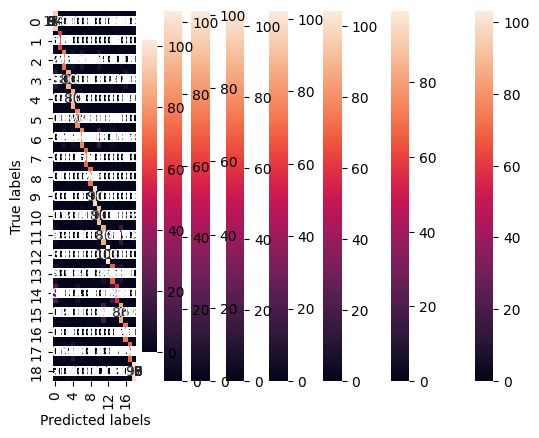

In [4]:
# Define the CNN model
def create_model(layer,opti_str):# Build the model
    model = Sequential()
    model.add(Conv2D(16, (3,3), padding='same', input_shape=(256,128,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(2, 2))
    for x in range(layer):
        model.add(Dropout(0.2))
        model.add(Conv2D(16, (3,3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(19, activation='softmax'))
    optimizer=RMSprop(learning_rate=0.001)
    if opti_str == 'ADAM':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# Dropout-Layers after MaxPooling-Layers seem to be a known issue currently: https://github.com/tensorflow/tensorflow/issues/61324
# The following line is to suppress the error.
with options({"layout_optimizer": False}):
    for layer, opti_str in [(3,'RMSP'),(2,'ADAM')]:
        for bs in range(4):
            title_appendix = f'CNN_layer={layer+1}_optimizer={opti_str}_batchsize={pow(2,4+bs)}'
            print('Number of layers: %.i; Optimizer: %s; Batchsize: %.i' % (layer+1, opti_str, pow(2,4+bs)))
            kfold = KFold(n_splits=5, shuffle=True, random_state=42)
            lss = []
            acc = []
            # Training with cross-validation
            for train, test in kfold.split(X_train, y_train):
                model = create_model(layer,opti_str)
                early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=1, mode='auto')
                model.fit(X_train[train], y_train[train], epochs=100, batch_size=pow(2,4+bs), verbose=0, callbacks=[early_stopping])
                score = model.evaluate(X_train[test], y_train[test], verbose=0)
                lss.append(score[0])
                acc.append(score[1])
                print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')
            print(f'Average Model Performance: Loss: {sum(lss)/len(lss)}; Accuracy: {sum(acc)/len(acc)}')
            
            loss, accuracy = model.evaluate(X_test, y_test)
            print(f'Validation Performance: Loss: {loss}; Accuracy: {accuracy}')

            generate_confusion_matrix(X_test, y_test, title_appendix)
            
            # Clear Keras session
            K.clear_session()
            del model
            gc.collect()

Number of layers: 3; Optimizer: ADAM; Batchsize: 64
Epoch 36: early stopping
Test loss: 0.7482515573501587, Test accuracy: 0.8283942341804504
Epoch 45: early stopping
Test loss: 1.1618828773498535, Test accuracy: 0.7856650352478027
Epoch 43: early stopping
Test loss: 0.6247854828834534, Test accuracy: 0.8463128805160522
Epoch 38: early stopping
Test loss: 0.7957702875137329, Test accuracy: 0.817241370677948
Epoch 42: early stopping
Test loss: 0.6851301789283752, Test accuracy: 0.8455172181129456
Average Model Performance: Loss: 0.8031640768051147; Accuracy: 0.8246261477470398
57/57 [==============================] - 1s 9ms/step - loss: 0.6974 - accuracy: 0.8451
Validation Performance: Loss: 0.6973914504051208; Accuracy: 0.8450937271118164
57/57 [==============================] - 0s 6ms/step


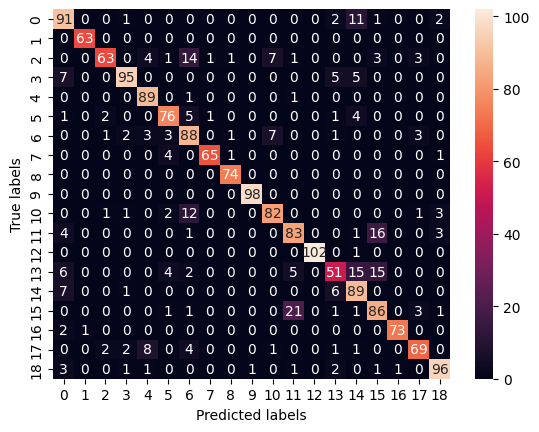

<Figure size 1000x800 with 0 Axes>

In [6]:
# Nur um die Confusionmatrix einmal richtig zu erzeugen
# Define the CNN model
def create_model(layer,opti_str):# Build the model
    model = Sequential()
    model.add(Conv2D(16, (3,3), padding='same', input_shape=(256,128,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(2, 2))
    for x in range(layer):
        model.add(Dropout(0.2))
        model.add(Conv2D(16, (3,3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(19, activation='softmax'))
    optimizer=RMSprop(learning_rate=0.001)
    if opti_str == 'ADAM':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# Dropout-Layers after MaxPooling-Layers seem to be a known issue currently: https://github.com/tensorflow/tensorflow/issues/61324
# The following line is to suppress the error.
with options({"layout_optimizer": False}):
    for layer, opti_str in [(2,'ADAM')]:
        for bs in range(2,3):
            title_appendix = f'CNN_layer={layer+1}_optimizer={opti_str}_batchsize={pow(2,4+bs)}'
            print('Number of layers: %.i; Optimizer: %s; Batchsize: %.i' % (layer+1, opti_str, pow(2,4+bs)))
            kfold = KFold(n_splits=5, shuffle=True, random_state=42)
            lss = []
            acc = []
            # Training with cross-validation
            for train, test in kfold.split(X_train, y_train):
                model = create_model(layer,opti_str)
                early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=1, mode='auto')
                model.fit(X_train[train], y_train[train], epochs=100, batch_size=pow(2,4+bs), verbose=0, callbacks=[early_stopping])
                score = model.evaluate(X_train[test], y_train[test], verbose=0)
                lss.append(score[0])
                acc.append(score[1])
                print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')
            print(f'Average Model Performance: Loss: {sum(lss)/len(lss)}; Accuracy: {sum(acc)/len(acc)}')
            
            loss, accuracy = model.evaluate(X_test, y_test)
            print(f'Validation Performance: Loss: {loss}; Accuracy: {accuracy}')

            generate_confusion_matrix(X_test, y_test, title_appendix)
            
            # Clear Keras session
            K.clear_session()
            del model
            gc.collect()

Interessehalber wird die Modelperformance auch für Inception-Layer anstelle von Convolution-MaxPooling-Layer-Paaren getestet.

In [4]:
# Dropout-Layers after MaxPooling-Layers seem to be a known issue currently: https://github.com/tensorflow/tensorflow/issues/61324
# The following line is to suppress the error.
with options({"layout_optimizer": False}):
    for opti_str in ['RMSP','ADAM']:
        for layer in range(1,7):
            for bs in range(2):
                title_appendix = f'CNN_nr_of_inception_layers={layer}_optimizer={opti_str}_batchsize={pow(2,5+bs)}'
                # Build the model
                model = Sequential()
                model.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
                model.add(MaxPooling2D(2, 2))
                for x in range(layer):
                    model.add(Dropout(0.2))
                    model.add(InceptionModule2(filters=16))
                model.add(Flatten())
                model.add(Dense(500, activation='relu'))
                model.add(Dense(19, activation='softmax'))
        
                
                optimizer=RMSprop(learning_rate=0.001)
                if opti_str == 'ADAM':
                    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
                model.compile(loss='categorical_crossentropy',
                              optimizer=optimizer,
                              metrics=['accuracy'])
                early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
                history = model.fit(X_train, y_train, epochs=50, batch_size=pow(2,5+bs), verbose=0, validation_split=0.2, callbacks=[early_stopping])
                
                # Evaluate the model
                loss, accuracy = model.evaluate(X_test, y_test)
                print('Number of layers: %.i; Optimizer: %s; Batchsize: %.i' % (layer, opti_str, pow(2,5+bs)))
                print(f"Final Training Loss: {history.history['loss'][-1]}")
                print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
                print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
                print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
                visualize_history(history, f'{title_appendix}_finacc={history.history["val_accuracy"][-1]:.2f}')
                
                # Clear Keras session
                K.clear_session()
                del model
                gc.collect()

2024-01-18 16:31:25.135131: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:227] Using CUDA malloc Async allocator for GPU: 0
2024-01-18 16:31:25.135244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7024 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-01-18 16:31:28.754841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-01-18 16:31:30.540105: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f073c044b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-18 16:31:30.540139: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-18 16:31:30.599495: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env 

Epoch 13: early stopping
57/57 [==============================] - 1s 22ms/step - loss: 0.7598 - accuracy: 0.8280
Number of layers: 1; Optimizer: RMSP; Batchsize: 32
Final Training Loss: 0.040205974131822586
Final Training Accuracy: 0.9881075620651245
Final Validation Loss: 0.7812396287918091
Final Validation Accuracy: 0.8242591023445129
Epoch 17: early stopping
57/57 [==============================] - 1s 20ms/step - loss: 0.7473 - accuracy: 0.8252
Number of layers: 1; Optimizer: RMSP; Batchsize: 64
Final Training Loss: 0.06978782266378403
Final Training Accuracy: 0.9827645421028137
Final Validation Loss: 0.6727607250213623
Final Validation Accuracy: 0.8290833830833435


2024-01-18 16:36:57.861289: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 1835008000 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 57016320/8510832640
2024-01-18 16:36:57.861314: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      7365263360
InUse:                      3932494948
MaxInUse:                   6815291700
NumAllocs:                      404712
MaxAllocSize:               1835008000
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-01-18 16:36:57.861325: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-01-18 16:36:57.861330: E tensorflow/compiler/xla/stream_execut

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 

Das scheint die Grafikkarte nicht mitzumachen. Daher nochmal für nur einen Layer aber dafür mit Cross-Validation.

In [7]:
def create_model(opti_str):
    # Build the model
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.2))
    model.add(InceptionModule2(filters=16))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(19, activation='softmax'))
    optimizer=RMSprop(learning_rate=0.001)
    if opti_str == 'ADAM':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# Dropout-Layers after MaxPooling-Layers seem to be a known issue currently: https://github.com/tensorflow/tensorflow/issues/61324
# The following line is to suppress the error.
with options({"layout_optimizer": False}):
    for opti_str in ['RMSP','ADAM']:
        for bs in range(2):
            title_appendix = f'inception_CNN_optimizer={opti_str}_batchsize={pow(2,4+bs)}'
            # Evaluate the model
            print('Optimizer: %s; Batchsize: %.i' % (opti_str, pow(2,5+bs)))
            kfold = KFold(n_splits=5, shuffle=True, random_state=42)
            lss = []
            acc = []
            # Training with cross-validation
            for train, test in kfold.split(X_train, y_train):
                model = create_model(opti_str)
                early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=1, mode='auto')
                model.fit(X_train[train], y_train[train], epochs=50, batch_size=pow(2,4+bs), verbose=0, callbacks=[early_stopping])
                score = model.evaluate(X_train[test], y_train[test], verbose=0)
                lss.append(score[0])
                acc.append(score[1])
                print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')
            print(f'Average Model Performance: Loss: {sum(lss)/len(lss)}; Accuracy: {sum(acc)/len(acc)}')
            
            loss, accuracy = model.evaluate(X_test, y_test)
            print(f'Validation Performance: Loss: {loss}; Accuracy: {accuracy}')

            generate_confusion_matrix(X_test, y_test, title_appendix)
            
            # Clear Keras session
            K.clear_session()
            del model
            gc.collect()

Optimizer: RMSP; Batchsize: 32
Epoch 25: early stopping
Test loss: 1.5782508850097656, Test accuracy: 0.8332184553146362


2024-01-18 20:10:15.847706: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 1048576000 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 253820928/8510832640
2024-01-18 20:10:15.847752: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      7313817600
InUse:                      6053400276
MaxInUse:                   6053400280
NumAllocs:                    51481695
MaxAllocSize:               1234183168
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-01-18 20:10:15.847785: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-01-18 20:10:15.847798: E tensorflow/compiler/xla/stream_execu

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: 

hätt ich mir denken können ...

## Rumgespiele

In [4]:
#del
for opti_str in ['RMSP','ADAM']:
    title_appendix = f'{opti_str}_e100_d250'
    for i in range(2,6):
        # Build the model
        model = Sequential()
        model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
        model.add(MaxPooling2D(2, 2))
        for x in range(5):
            for y in range(i):
                model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
            model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(Dense(250, activation='relu'))
        model.add(Dense(19, activation='softmax'))
    
        # Compile the model
        opti = RMSprop(learning_rate=0.001)
        if opti_str == 'ADAM':
            opti = tf.keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(loss='categorical_crossentropy',
                      optimizer=opti,
                      metrics=['accuracy'])
    
        # Fit the model
        history = model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=0, validation_split=0.2)
    
        # Evaluate the model
        loss, accuracy = model.evaluate(X_test, y_test)
        print('Number of additional convolution layers in between: %.i (%s)' % (i, opti_str))
        print(f"Final Training Loss: {history.history['loss'][-1]}")
        print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
        print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
        print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
        visualize_history(history, f'{title_appendix}_sublayercount={i}_finacc={history.history["val_accuracy"][-1]:.2f}')
    
    # Clear Keras session
    K.clear_session()
    del model
    gc.collect()

2024-01-15 09:02:32.438164: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:227] Using CUDA malloc Async allocator for GPU: 0
2024-01-15 09:02:32.438269: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7000 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-01-15 09:02:36.384578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-01-15 09:02:38.257146: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f795287b550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-15 09:02:38.257176: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-15 09:02:38.313372: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env 

57/57 [==============================] - 1s 10ms/step - loss: 1.5251 - accuracy: 0.8501
Number of additional convolution layers in between: 2 (RMSP)
Final Training Loss: 0.02549000270664692
Final Training Accuracy: 0.9915516972541809
Final Validation Loss: 1.3266136646270752
Final Validation Accuracy: 0.8579310178756714
57/57 [==============================] - 1s 8ms/step - loss: 2.9403 - accuracy: 0.0496
Number of additional convolution layers in between: 3 (RMSP)
Final Training Loss: 2.937068223953247
Final Training Accuracy: 0.053793102502822876
Final Validation Loss: 2.9395830631256104
Final Validation Accuracy: 0.05241379141807556
57/57 [==============================] - 1s 9ms/step - loss: 2.9402 - accuracy: 0.0496
Number of additional convolution layers in between: 4 (RMSP)
Final Training Loss: 2.937070608139038
Final Training Accuracy: 0.05344827473163605
Final Validation Loss: 2.9395265579223633
Final Validation Accuracy: 0.05241379141807556
57/57 [============================

Für RMS-Propagation scheint das Model mit mehr als 2 Convolutional Sublayern instabil zu werden (fransiger Plot + unterirdische Genauigkeit).

Beim Adam-Optimizer higegen scheint dass erhöhen der Convolutional Sublayer die Performace des Models nicht direkt zu beeinflussen. 

Kann eine andere Batchsize hier zu besseren Ergebnissen führen? Um Overfitting zu verhindern und Ressourcen zu sparen wird außerdem zusätzlich Early Stopping eingebaut.

In [5]:
for opti_str in ['RMSP','ADAM']:
    for bs in [5, 10, 25, 50, 100 ]:
        title_appendix = f'{opti_str}_ bs{bs}_e100_d250'
        for i in range(1,6):
            # Build the model
            model = Sequential()
            model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
            model.add(MaxPooling2D(2, 2))
            for x in range(5):
                for y in range(i):
                    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
                model.add(MaxPooling2D(2, 2))
            model.add(Flatten())
            model.add(Dense(250, activation='relu'))
            model.add(Dense(19, activation='softmax'))
        
            # Compile the model
            opti = RMSprop(learning_rate=0.001)
            if opti_str == 'ADAM':
                opti = tf.keras.optimizers.Adam(learning_rate=0.0001)
            model.compile(loss='categorical_crossentropy',
                          optimizer=opti,
                          metrics=['accuracy'])
        
            # Fit the model
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
            history = model.fit(X_train, y_train, 
                                epochs=100, 
                                batch_size=bs, 
                                verbose=0, 
                                validation_split=0.2, 
                                callbacks=[early_stopping])
            # Evaluate the model
            loss, accuracy = model.evaluate(X_test, y_test)
            print('Number of additional convolution layers in between: %.i (%s, batchsize: %.i)' % (i, opti_str, bs))
            print(f"Final Training Loss: {history.history['loss'][-1]}")
            print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
            print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
            print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
            visualize_history(history, f'{title_appendix}_sublayercount={i}_finacc={history.history["val_accuracy"][-1]:.2f}')
            
            # Clear Keras session
            K.clear_session()
            del model
            gc.collect()

2024-01-15 11:26:52.340578: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:227] Using CUDA malloc Async allocator for GPU: 0
2024-01-15 11:26:52.340650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6889 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-01-15 11:26:54.990222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-01-15 11:26:55.535946: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f80c9a61280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-15 11:26:55.535967: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-15 11:26:55.539887: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env 

Epoch 13: early stopping
57/57 [==============================] - 1s 10ms/step - loss: 0.5720 - accuracy: 0.8037
Number of additional convolution layers in between: 1 (RMSP, batchsize: 5)
Final Training Loss: 0.4000765383243561
Final Training Accuracy: 0.8641379475593567
Final Validation Loss: 0.5638492703437805
Final Validation Accuracy: 0.8103448152542114
Epoch 10: early stopping
57/57 [==============================] - 1s 8ms/step - loss: 2.9412 - accuracy: 0.0419
Number of additional convolution layers in between: 2 (RMSP, batchsize: 5)
Final Training Loss: 2.9378814697265625
Final Training Accuracy: 0.05206896737217903
Final Validation Loss: 2.939415454864502
Final Validation Accuracy: 0.06275861710309982
Epoch 10: early stopping
57/57 [==============================] - 1s 9ms/step - loss: 2.9409 - accuracy: 0.0485
Number of additional convolution layers in between: 3 (RMSP, batchsize: 5)
Final Training Loss: 2.938035011291504
Final Training Accuracy: 0.05000000074505806
Final Val

2024-01-15 13:53:33.632860: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 419430400 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 175439872/8510832640
2024-01-15 13:53:33.632915: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      7223967744
InUse:                      6364151756
MaxInUse:                   6965338016
NumAllocs:                    88047801
MaxAllocSize:               2248708096
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-01-15 13:53:33.632969: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-01-15 13:53:33.632983: E tensorflow/compiler/xla/stream_execut

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start
      self.io_loop.start()
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell
      await result
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_28615/1778880752.py", line 30, in <module>
      history = model.fit(X_train, y_train,
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/home/firefly-rgb/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad'
OOM when allocating tensor with shape[100,32,256,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator gpu_async_0
	 [[{{node gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2179997]

In [4]:
# Varrie the number of layers
# convolutional filters: 32; epochs: 100; density: 250, rms_propagation learning rate:
for opti_str in ['RMSP','ADAM']:
    for bs in [5, 25]:
        title_appendix = f'{opti_str}_ bs{bs}_e100_d250'
        for i in range(1,6):
            # Build the model
            model = Sequential()
            model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
            model.add(MaxPooling2D(2, 2))
            for x in range(i):
                model.add(InceptionModule(filters=32))
                model.add(MaxPooling2D(2, 2))
            model.add(Flatten())
            model.add(Dense(250, activation='relu'))
            model.add(Dense(19, activation='softmax'))
        
            # Compile the model
            opti = RMSprop(learning_rate=0.001)
            if opti_str == 'ADAM':
                opti = tf.keras.optimizers.Adam(learning_rate=0.0001)
            model.compile(loss='categorical_crossentropy',
                          optimizer=opti,
                          metrics=['accuracy'])
        
            # Fit the model
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='auto')
            history = model.fit(X_train, y_train, 
                                epochs=100, 
                                batch_size=bs, 
                                verbose=0, 
                                validation_split=0.2, 
                                callbacks=[early_stopping])
            # Evaluate the model
            loss, accuracy = model.evaluate(X_test, y_test)
            print('Number of inception layers: %.i (%s, batchsize: %.i)' % (i, opti_str, bs))
            print(f"Final Training Loss: {history.history['loss'][-1]}")
            print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
            print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
            print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
            visualize_history(history, f'inception_{title_appendix}_sublayercount={i}_finacc={history.history["val_accuracy"][-1]:.2f}')

            # Clear Keras session
            K.clear_session()
            del model
            gc.collect()

2024-01-15 19:01:49.310907: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:227] Using CUDA malloc Async allocator for GPU: 0
2024-01-15 19:01:49.310971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6866 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-01-15 19:01:51.814664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-01-15 19:01:52.339485: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f05191e7500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-15 19:01:52.339510: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-15 19:01:52.343442: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env 

Epoch 10: early stopping
57/57 [==============================] - 1s 18ms/step - loss: 1.7996 - accuracy: 0.7845
Number of inception layers: 1 (RMSP, batchsize: 5)
Final Training Loss: 0.017035244032740593
Final Training Accuracy: 0.9950000047683716
Final Validation Loss: 1.8507038354873657
Final Validation Accuracy: 0.7799999713897705
Epoch 12: early stopping
57/57 [==============================] - 1s 17ms/step - loss: 1.9841 - accuracy: 0.8104
Number of inception layers: 2 (RMSP, batchsize: 5)
Final Training Loss: 0.02317635715007782
Final Training Accuracy: 0.9929310083389282
Final Validation Loss: 1.8488867282867432
Final Validation Accuracy: 0.8227586150169373
Epoch 14: early stopping
57/57 [==============================] - 1s 16ms/step - loss: 1.6534 - accuracy: 0.8247
Number of inception layers: 3 (RMSP, batchsize: 5)
Final Training Loss: 0.05556110665202141
Final Training Accuracy: 0.9837930798530579
Final Validation Loss: 1.4771275520324707
Final Validation Accuracy: 0.82827

In [4]:
# Varrie the number of layers
# convolutional filters: 32; epochs: 100; density: 250, rms_propagation learning rate:
for opti_str in ['RMSP', 'ADAM']:
    for fs in [16,64]:
        for bs in [5,25,50]:
            title_appendix = f'{opti_str}_ fs{fs}_bs{bs}_e100_d250'
            for i in range(1,6):
                # Build the model
                model = Sequential()
                model.add(Conv2D(fs, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
                model.add(MaxPooling2D(2, 2))
                for x in range(i):
                    model.add(InceptionModule(filters=fs))
                    model.add(MaxPooling2D(2, 2))
                model.add(Flatten())
                model.add(Dense(250, activation='relu'))
                model.add(Dense(19, activation='softmax'))
            
                # Compile the model
                opti = RMSprop(learning_rate=0.001)
                if opti_str == 'ADAM':
                    opti = tf.keras.optimizers.Adam(learning_rate=0.0001)
                model.compile(loss='categorical_crossentropy',
                              optimizer=opti,
                              metrics=['accuracy'])
            
                # Fit the model
                early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
                history = model.fit(X_train, y_train, 
                                    epochs=100, 
                                    batch_size=bs, 
                                    verbose=0, 
                                    validation_split=0.2, 
                                    callbacks=[early_stopping])
                # Evaluate the model
                loss, accuracy = model.evaluate(X_test, y_test)
                print('Number of inception layers: %.i (%s, batchsize: %.i)' % (i, opti_str, bs))
                print(f"Final Training Loss: {history.history['loss'][-1]}")
                print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
                print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
                print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
                visualize_history(history, f'inception_{title_appendix}_sublayercount={i}_finacc={history.history["val_accuracy"][-1]:.2f}')
    
                # Clear Keras session
                K.clear_session()
                del model
                gc.collect()

2024-01-16 09:55:33.299535: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:227] Using CUDA malloc Async allocator for GPU: 0
2024-01-16 09:55:33.299599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7020 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-01-16 09:55:35.776631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-01-16 09:55:36.280123: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc7fc02d0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-16 09:55:36.280145: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-16 09:55:36.283985: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env 

Epoch 15: early stopping
57/57 [==============================] - 1s 13ms/step - loss: 1.6217 - accuracy: 0.8418
Number of inception layers: 1 (RMSP, batchsize: 5)
Final Training Loss: 2.764451437542448e-06
Final Training Accuracy: 1.0
Final Validation Loss: 1.6036280393600464
Final Validation Accuracy: 0.839310348033905
Epoch 15: early stopping
57/57 [==============================] - 1s 11ms/step - loss: 2.0767 - accuracy: 0.8390
Number of inception layers: 2 (RMSP, batchsize: 5)
Final Training Loss: 0.013805396854877472
Final Training Accuracy: 0.997586190700531
Final Validation Loss: 1.9938232898712158
Final Validation Accuracy: 0.838620662689209
Epoch 17: early stopping
57/57 [==============================] - 1s 11ms/step - loss: 1.5897 - accuracy: 0.8286
Number of inception layers: 3 (RMSP, batchsize: 5)
Final Training Loss: 0.04686996340751648
Final Training Accuracy: 0.9891379475593567
Final Validation Loss: 1.4806262254714966
Final Validation Accuracy: 0.8413792848587036
Epoc

2024-01-16 11:37:38.742880: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 3872276480 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 172163072/8510832640
2024-01-16 11:37:38.742907: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      7361527808
InUse:                      2533783028
MaxInUse:                   6300677620
NumAllocs:                    42541048
MaxAllocSize:               3872014336
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-01-16 11:37:38.742922: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-01-16 11:37:38.742932: E tensorflow/compiler/xla/stream_execu

Epoch 20: early stopping
57/57 [==============================] - 2s 28ms/step - loss: 0.8372 - accuracy: 0.8225
Number of inception layers: 1 (RMSP, batchsize: 50)
Final Training Loss: 0.030646998435258865
Final Training Accuracy: 0.9948275685310364
Final Validation Loss: 0.7750986814498901
Final Validation Accuracy: 0.8289655447006226
Epoch 19: early stopping
57/57 [==============================] - 2s 26ms/step - loss: 1.1205 - accuracy: 0.8396
Number of inception layers: 2 (RMSP, batchsize: 50)
Final Training Loss: 0.016368580982089043
Final Training Accuracy: 0.994655191898346
Final Validation Loss: 1.0896378755569458
Final Validation Accuracy: 0.8303448557853699
Epoch 18: early stopping
57/57 [==============================] - 2s 26ms/step - loss: 1.0342 - accuracy: 0.8506
Number of inception layers: 3 (RMSP, batchsize: 50)
Final Training Loss: 0.025272224098443985
Final Training Accuracy: 0.9932758808135986
Final Validation Loss: 0.8827308416366577
Final Validation Accuracy: 0.8

In [5]:
# Varrie the number of layers
# convolutional filters: 32; epochs: 100; density: 250, rms_propagation learning rate:
for opti_str in ['RMSP', 'ADAM']:
    for fs in [64,128]:
        for bs in [5,25,50]:
            title_appendix = f'{opti_str}_ fs{fs}_bs{bs}_e100_d250'
            for i in range(6,11):
                # Build the model
                model = Sequential()
                model.add(Conv2D(fs, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
                model.add(MaxPooling2D(2, 2))
                for x in range(i):
                    model.add(InceptionModule(filters=fs))
                    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
                model.add(Flatten())
                model.add(Dense(250, activation='relu'))
                model.add(Dense(19, activation='softmax'))
            
                # Compile the model
                opti = RMSprop(learning_rate=0.001)
                if opti_str == 'ADAM':
                    opti = tf.keras.optimizers.Adam(learning_rate=0.0001)
                model.compile(loss='categorical_crossentropy',
                              optimizer=opti,
                              metrics=['accuracy'])
            
                # Fit the model
                early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
                history = model.fit(X_train, y_train, 
                                    epochs=100, 
                                    batch_size=bs, 
                                    verbose=0, 
                                    validation_split=0.2, 
                                    callbacks=[early_stopping])
                # Evaluate the model
                loss, accuracy = model.evaluate(X_test, y_test)
                print('Number of inception layers: %.i (%s, batchsize: %.i, filtersize: %.i)' % (i, opti_str, bs, fs))
                print(f"Final Training Loss: {history.history['loss'][-1]}")
                print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
                print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
                print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
                visualize_history(history, f'inception_{title_appendix}_sublayercount={i}_finacc={history.history["val_accuracy"][-1]:.2f}')
    
                # Clear Keras session
                K.clear_session()
                del model
                gc.collect()

2024-01-16 16:19:03.012352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-01-16 16:19:03.923259: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1f7825e520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-16 16:19:03.923283: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-16 16:19:03.927377: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-16 16:19:04.026918: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 20: early stopping
57/57 [==============================] - 4s 41ms/step - loss: 0.8639 - accuracy: 0.7861
Number of inception layers: 6 (RMSP, batchsize: 5, filtersize: 64)
Final Training Loss: 0.5793085694313049
Final Training Accuracy: 0.8322413563728333
Final Validation Loss: 0.6257495880126953
Final Validation Accuracy: 0.8124138116836548
Epoch 18: early stopping
57/57 [==============================] - 2s 27ms/step - loss: 1.4180 - accuracy: 0.7933
Number of inception layers: 7 (RMSP, batchsize: 5, filtersize: 64)
Final Training Loss: 0.6847610473632812
Final Training Accuracy: 0.7908620834350586
Final Validation Loss: 1.0126256942749023
Final Validation Accuracy: 0.795862078666687
Epoch 18: early stopping
57/57 [==============================] - 2s 27ms/step - loss: 0.9070 - accuracy: 0.7078
Number of inception layers: 8 (RMSP, batchsize: 5, filtersize: 64)
Final Training Loss: 0.8827313184738159
Final Training Accuracy: 0.7336207032203674
Final Validation Loss: 0.84924763

2024-01-16 17:58:45.524095: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 3872276480 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 189399040/8510832640
2024-01-16 17:58:45.524122: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      7343308800
InUse:                      1780429468
MaxInUse:                   5547324060
NumAllocs:                    52222838
MaxAllocSize:               3872014336
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-01-16 17:58:45.524139: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-01-16 17:58:45.524145: E tensorflow/compiler/xla/stream_execu

Epoch 24: early stopping
57/57 [==============================] - 2s 25ms/step - loss: 0.6056 - accuracy: 0.8600
Number of inception layers: 6 (RMSP, batchsize: 50, filtersize: 64)
Final Training Loss: 0.07514721155166626
Final Training Accuracy: 0.9743103384971619
Final Validation Loss: 0.5782197117805481
Final Validation Accuracy: 0.8455172181129456
Epoch 29: early stopping
57/57 [==============================] - 2s 26ms/step - loss: 0.8576 - accuracy: 0.8760
Number of inception layers: 7 (RMSP, batchsize: 50, filtersize: 64)
Final Training Loss: 0.06016116961836815
Final Training Accuracy: 0.9824137687683105
Final Validation Loss: 0.7358242869377136
Final Validation Accuracy: 0.869655191898346
Epoch 34: early stopping
57/57 [==============================] - 2s 27ms/step - loss: 0.8205 - accuracy: 0.8705
Number of inception layers: 8 (RMSP, batchsize: 50, filtersize: 64)
Final Training Loss: 0.07935906946659088
Final Training Accuracy: 0.9751724004745483
Final Validation Loss: 0.75

2024-01-16 18:41:53.874966: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 6565134336 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 92667904/8510832640
2024-01-16 18:41:53.874994: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      7343308800
InUse:                      1186059704
MaxInUse:                   5862581572
NumAllocs:                    59270678
MaxAllocSize:               3872276480
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-01-16 18:41:53.875013: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-01-16 18:41:53.875018: E tensorflow/compiler/xla/stream_execut

Epoch 25: early stopping
57/57 [==============================] - 7s 83ms/step - loss: 0.9079 - accuracy: 0.7370
Number of inception layers: 6 (RMSP, batchsize: 5, filtersize: 128)
Final Training Loss: 0.6113438606262207
Final Training Accuracy: 0.8286206722259521
Final Validation Loss: 0.8049278259277344
Final Validation Accuracy: 0.7220689654350281
Epoch 18: early stopping
57/57 [==============================] - 4s 61ms/step - loss: 1.0353 - accuracy: 0.7740
Number of inception layers: 7 (RMSP, batchsize: 5, filtersize: 128)
Final Training Loss: 0.7488276958465576
Final Training Accuracy: 0.7865517139434814
Final Validation Loss: 0.80855393409729
Final Validation Accuracy: 0.7875862121582031
Epoch 18: early stopping
57/57 [==============================] - 4s 61ms/step - loss: 1.7018 - accuracy: 0.6792
Number of inception layers: 8 (RMSP, batchsize: 5, filtersize: 128)
Final Training Loss: 0.9560306668281555
Final Training Accuracy: 0.7268965244293213
Final Validation Loss: 1.178835

2024-01-16 20:36:11.520738: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 6586105856 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 101318656/8510832640
2024-01-16 20:36:11.520763: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      7343308800
InUse:                      2354249736
MaxInUse:                   5862581572
NumAllocs:                    98919251
MaxAllocSize:               3872276480
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-01-16 20:36:11.520780: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-01-16 20:36:11.520784: E tensorflow/compiler/xla/stream_execu

Epoch 22: early stopping
57/57 [==============================] - 4s 59ms/step - loss: 0.8162 - accuracy: 0.8567
Number of inception layers: 6 (RMSP, batchsize: 25, filtersize: 128)
Final Training Loss: 0.10968565940856934
Final Training Accuracy: 0.9653448462486267
Final Validation Loss: 0.6077407598495483
Final Validation Accuracy: 0.8510344624519348
Epoch 22: early stopping
57/57 [==============================] - 4s 59ms/step - loss: 0.9809 - accuracy: 0.8512
Number of inception layers: 7 (RMSP, batchsize: 25, filtersize: 128)
Final Training Loss: 0.15752045810222626
Final Training Accuracy: 0.9498276114463806
Final Validation Loss: 0.7261333465576172
Final Validation Accuracy: 0.8544827699661255
Epoch 24: early stopping
57/57 [==============================] - 4s 60ms/step - loss: 0.6437 - accuracy: 0.8335
Number of inception layers: 8 (RMSP, batchsize: 25, filtersize: 128)
Final Training Loss: 0.21454960107803345
Final Training Accuracy: 0.9356896281242371
Final Validation Loss: 

2024-01-16 22:01:02.317823: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 3948937216 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 202702848/8510832640
2024-01-16 22:01:02.317850: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      7343308800
InUse:                      3667660484
MaxInUse:                   5884808900
NumAllocs:                   109880800
MaxAllocSize:               3872276480
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-01-16 22:01:02.317869: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-01-16 22:01:02.317874: E tensorflow/compiler/xla/stream_execu

Epoch 24: early stopping
57/57 [==============================] - 3s 55ms/step - loss: 0.5605 - accuracy: 0.8804
Number of inception layers: 6 (RMSP, batchsize: 50, filtersize: 128)
Final Training Loss: 0.06856274604797363
Final Training Accuracy: 0.978620707988739
Final Validation Loss: 0.5663509368896484
Final Validation Accuracy: 0.8627586364746094
Epoch 27: early stopping
57/57 [==============================] - 3s 56ms/step - loss: 0.8798 - accuracy: 0.8418
Number of inception layers: 7 (RMSP, batchsize: 50, filtersize: 128)
Final Training Loss: 0.11138313263654709
Final Training Accuracy: 0.966724157333374
Final Validation Loss: 0.7684637904167175
Final Validation Accuracy: 0.8489655256271362
Epoch 27: early stopping
57/57 [==============================] - 4s 57ms/step - loss: 0.8201 - accuracy: 0.8374
Number of inception layers: 8 (RMSP, batchsize: 50, filtersize: 128)
Final Training Loss: 0.12528003752231598
Final Training Accuracy: 0.9625862240791321
Final Validation Loss: 0.